In [ ]:
#####################################################################################

In [2]:
# ====================================================
# ✅ Step 0: Install and check library versions
# ====================================================
!pip install -q tensorflow==2.19.0 tensorflow-text==2.19.0 transformers==4.57.1
!pip install -q pandas numpy seaborn matplotlib scikit-learn wordcloud evaluate


In [3]:
# ====================================================
# ✅ Step 1: Imports and GPU check
# ====================================================
import os, re, random, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Version check
print("✅ TensorFlow version:", tf.__version__)
import transformers
print("✅ Transformers version:", transformers.__version__)
print("✅ GPUs detected:", tf.config.list_physical_devices('GPU'))


✅ TensorFlow version: 2.19.0
✅ Transformers version: 4.57.1
✅ GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# ====================================================
# ✅ Step 2: Load Sentiment140 dataset
# ====================================================
path = "/content/training.1600000.processed.noemoticon.csv"
col_names = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(path, encoding="latin-1", names=col_names)
print("✅ Data loaded:", df.shape)
print(df.head())


✅ Data loaded: (1600000, 6)
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [5]:
# ====================================================
# ✅ Step 3: Binary labels (0=neg, 4=pos)
# ====================================================
print("\nOriginal label value counts:")
print(df['target'].value_counts())

df = df[df['target'].isin([0,4])].copy()
df['label'] = df['target'].map({0:0, 4:1})
print("Filtered rows (0 & 4):", len(df))
print(df['label'].value_counts())



Original label value counts:
target
0    800000
4    800000
Name: count, dtype: int64
Filtered rows (0 & 4): 1600000
label
0    800000
1    800000
Name: count, dtype: int64


In [6]:
# ====================================================
# ✅ Step 4: Clean tweets
# ====================================================
def clean_tweet(s):
    s = str(s)
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'@\w+', '', s)
    s = re.sub(r'#', '', s)
    s = re.sub(r'[^A-Za-z0-9\'\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s.lower()

df['text_clean'] = df['text'].apply(clean_tweet)
df['word_count'] = df['text_clean'].apply(lambda x: len(x.split()))
df['char_count'] = df['text_clean'].apply(len)

print("\nText length stats:")
print(df[['word_count','char_count']].describe())



Text length stats:
         word_count    char_count
count  1.600000e+06  1.600000e+06
mean   1.275241e+01  6.300203e+01
std    7.059574e+00  3.461454e+01
min    0.000000e+00  0.000000e+00
25%    7.000000e+00  3.400000e+01
50%    1.200000e+01  5.800000e+01
75%    1.800000e+01  9.000000e+01
max    5.200000e+01  1.950000e+02


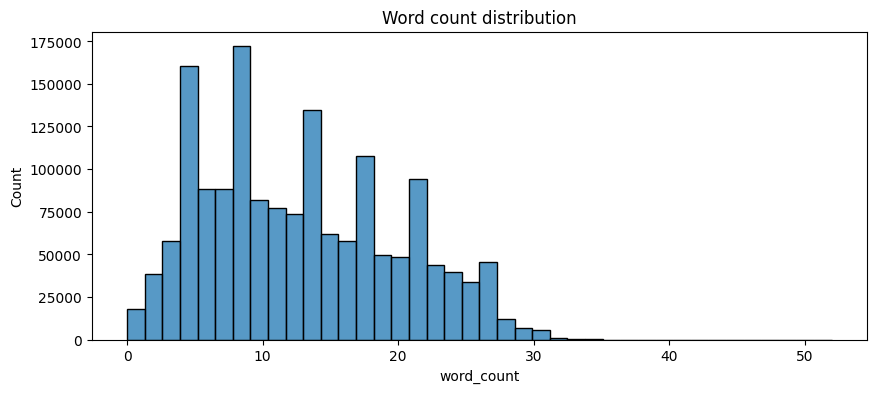

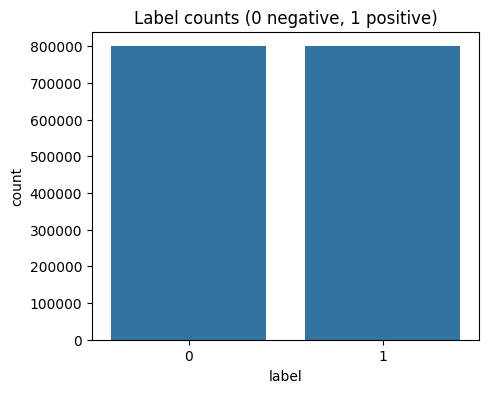

In [7]:
plt.figure(figsize=(10,4))
sns.histplot(df['word_count'], bins=40)
plt.title('Word count distribution')
plt.show()

plt.figure(figsize=(5,4))
sns.countplot(x='label', data=df)
plt.title('Label counts (0 negative, 1 positive)')
plt.show()


/tmp/ipython-input-4013311617.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


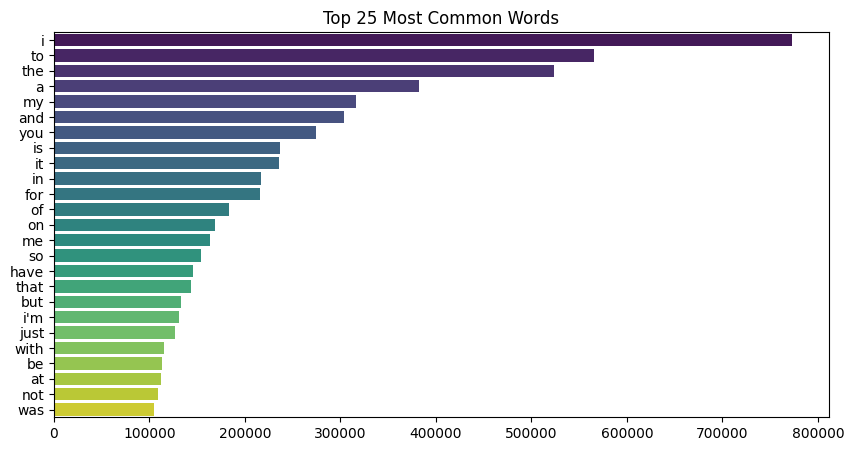

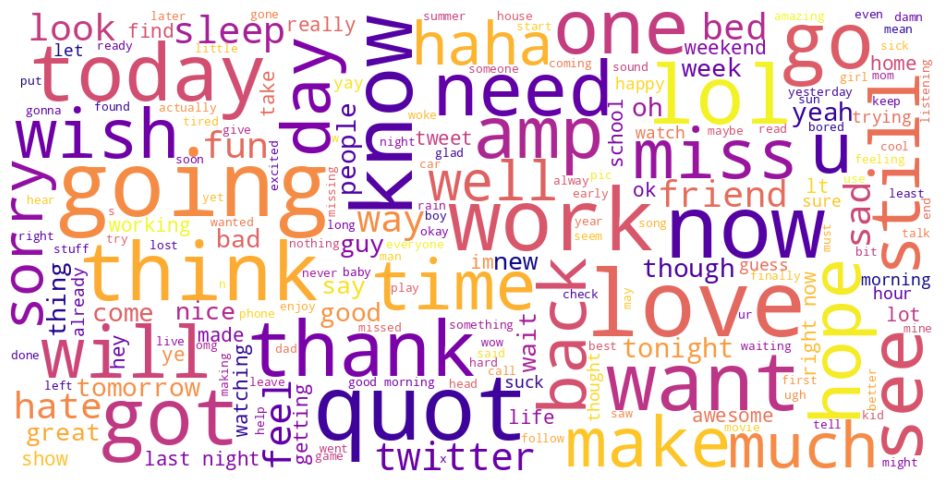

In [8]:
from collections import Counter
from wordcloud import WordCloud

all_words = " ".join(df['text_clean']).split()
counter = Counter(all_words)
common_words = counter.most_common(25)

words, counts = zip(*common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette="viridis")
plt.title("Top 25 Most Common Words")
plt.show()

plt.figure(figsize=(12,6))
wordcloud = WordCloud(
    width=1000, height=500, background_color='white',
    colormap='plasma', max_words=200, max_font_size=100
).generate(" ".join(df['text_clean']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
# ====================================================
# ✅ Step 5: Split data
# ====================================================
RND = 42
train_df, test_df = train_test_split(df, test_size=0.10, stratify=df['label'], random_state=RND)
train_df, val_df = train_test_split(train_df, test_size=0.1111, stratify=train_df['label'], random_state=RND)

TRAIN_SAMPLE = 100000
VAL_SAMPLE   = 8000
TEST_SAMPLE  = 8000

train_df = train_df.sample(n=min(TRAIN_SAMPLE, len(train_df)), random_state=RND)
val_df   = val_df.sample(n=min(VAL_SAMPLE, len(val_df)), random_state=RND)
test_df  = test_df.sample(n=min(TEST_SAMPLE, len(test_df)), random_state=RND)

print("Using samples: train", len(train_df), "val", len(val_df), "test", len(test_df))

X_train, y_train = train_df['text_clean'].values, train_df['label'].values
X_val, y_val     = val_df['text_clean'].values, val_df['label'].values
X_test, y_test   = test_df['text_clean'].values, test_df['label'].values


Using samples: train 100000 val 8000 test 8000


In [10]:
# ====================================================
# ✅ Step 6: TextVectorization
# ====================================================
MAX_VOCAB = 30000
MAX_LEN = 80
EMBED_DIM = 128

vectorizer = TextVectorization(max_tokens=MAX_VOCAB, output_mode='int', output_sequence_length=MAX_LEN)
vectorizer.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(2048))
vocab = vectorizer.get_vocabulary()
print("Vectorizer vocab size:", len(vocab))


Vectorizer vocab size: 30000


In [11]:
# ====================================================
# ✅ ANN Model: Build, Train & Evaluate
# ====================================================

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
BATCH_SIZE = 256
EPOCHS = 4

def build_ann():
    inp = keras.Input(shape=(), dtype=tf.string)
    x = vectorizer(inp)                      # FIXED
    x = layers.Embedding(len(vocab), EMBED_DIM)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print("\n--- TRAINING ANN ---")
ann = build_ann()
history_ann = ann.fit(X_train, y_train, validation_data=(X_val, y_val),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early], verbose=2)

print("\n--- EVALUATING ANN ---")
preds_prob_ann = ann.predict(X_test, batch_size=512).ravel()
preds_ann = (preds_prob_ann >= 0.5).astype(int)
print(classification_report(y_test, preds_ann, digits=4))
print(confusion_matrix(y_test, preds_ann))



--- TRAINING ANN ---
Epoch 1/4
391/391 - 8s - 20ms/step - accuracy: 0.6460 - loss: 0.6152 - val_accuracy: 0.6758 - val_loss: 0.5977
Epoch 2/4
391/391 - 3s - 8ms/step - accuracy: 0.7627 - loss: 0.4954 - val_accuracy: 0.7487 - val_loss: 0.5157
Epoch 3/4
391/391 - 5s - 13ms/step - accuracy: 0.7835 - loss: 0.4653 - val_accuracy: 0.7513 - val_loss: 0.5201
Epoch 4/4
391/391 - 4s - 9ms/step - accuracy: 0.8031 - loss: 0.4350 - val_accuracy: 0.7621 - val_loss: 0.4950

--- EVALUATING ANN ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0     0.7319    0.8712    0.7955      3990
           1     0.8419    0.6825    0.7539      4010

    accuracy                         0.7766      8000
   macro avg     0.7869    0.7769    0.7747      8000
weighted avg     0.7871    0.7766    0.7747      8000

[[3476  514]
 [1273 2737]]


In [12]:
# ====================================================
# ✅ BiLSTM Model
# ====================================================

def build_bilstm():
    inp = keras.Input(shape=(), dtype=tf.string)
    x = vectorizer(inp)
    x = layers.Embedding(len(vocab), EMBED_DIM)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print("\n--- TRAINING BiLSTM ---")
bilstm = build_bilstm()
history_bilstm = bilstm.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early], verbose=2)

print("\n--- EVALUATING BiLSTM ---")
preds_prob_bilstm = bilstm.predict(X_test, batch_size=512).ravel()
preds_bilstm = (preds_prob_bilstm >= 0.5).astype(int)
print(classification_report(y_test, preds_bilstm, digits=4))
print(confusion_matrix(y_test, preds_bilstm))



--- TRAINING BiLSTM ---
Epoch 1/4
391/391 - 10s - 25ms/step - accuracy: 0.7534 - loss: 0.5021 - val_accuracy: 0.7866 - val_loss: 0.4640
Epoch 2/4
391/391 - 7s - 17ms/step - accuracy: 0.8216 - loss: 0.3964 - val_accuracy: 0.7853 - val_loss: 0.4628
Epoch 3/4
391/391 - 7s - 18ms/step - accuracy: 0.8509 - loss: 0.3380 - val_accuracy: 0.7869 - val_loss: 0.4853
Epoch 4/4
391/391 - 7s - 18ms/step - accuracy: 0.8751 - loss: 0.2835 - val_accuracy: 0.7821 - val_loss: 0.5388

--- EVALUATING BiLSTM ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
              precision    recall  f1-score   support

           0     0.7957    0.8065    0.8011      3990
           1     0.8049    0.7940    0.7994      4010

    accuracy                         0.8003      8000
   macro avg     0.8003    0.8003    0.8002      8000
weighted avg     0.8003    0.8003    0.8002      8000

[[3218  772]
 [ 826 3184]]


In [13]:
# ====================================================
# ✅ CNN1D Model
# ====================================================

def build_cnn1d():
    inp = keras.Input(shape=(), dtype=tf.string)
    x = vectorizer(inp)
    x = layers.Embedding(len(vocab), EMBED_DIM)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print("\n--- TRAINING CNN1D ---")
cnn1d = build_cnn1d()
history_cnn1d = cnn1d.fit(X_train, y_train, validation_data=(X_val, y_val),
                          epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early], verbose=2)

print("\n--- EVALUATING CNN1D ---")
preds_prob_cnn1d = cnn1d.predict(X_test, batch_size=512).ravel()
preds_cnn1d = (preds_prob_cnn1d >= 0.5).astype(int)
print(classification_report(y_test, preds_cnn1d, digits=4))
print(confusion_matrix(y_test, preds_cnn1d))



--- TRAINING CNN1D ---
Epoch 1/4
391/391 - 8s - 21ms/step - accuracy: 0.7575 - loss: 0.4919 - val_accuracy: 0.7895 - val_loss: 0.4522
Epoch 2/4
391/391 - 4s - 10ms/step - accuracy: 0.8416 - loss: 0.3651 - val_accuracy: 0.7874 - val_loss: 0.4593
Epoch 3/4
391/391 - 5s - 12ms/step - accuracy: 0.9023 - loss: 0.2452 - val_accuracy: 0.7851 - val_loss: 0.5172

--- EVALUATING CNN1D ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
              precision    recall  f1-score   support

           0     0.7887    0.8221    0.8050      3990
           1     0.8152    0.7808    0.7976      4010

    accuracy                         0.8014      8000
   macro avg     0.8019    0.8014    0.8013      8000
weighted avg     0.8019    0.8014    0.8013      8000

[[3280  710]
 [ 879 3131]]


In [ ]:
####transformers

In [20]:
# ====================================================
# ✅ Step 9: DistilBERT Transformer
# ====================================================
# Install the evaluate library
!pip install -q evaluate

import re
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import evaluate

# ------------------------------------------------
# 1️⃣ Prepare data for Hugging Face Datasets
# ------------------------------------------------
# The data needs to be in a format compatible with Hugging Face's datasets library.
# We'll create a dictionary and then convert it to a Dataset object.

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined from previous steps
# (e.g., from cell saH-H6tEHbx6)

# Create dictionaries for train and test datasets
train_dict = {'text': X_train.tolist(), 'label': y_train.tolist()}
test_dict = {'text': X_test.tolist(), 'label': y_test.tolist()} # Use X_test and y_test for evaluation

# Convert dictionaries to Dataset objects
train_ds = Dataset.from_dict(train_dict)
test_ds = Dataset.from_dict(test_dict)

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)


# ------------------------------------------------
# 2️⃣ Tokenization
# ------------------------------------------------
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

print("\nTokenized train dataset:", train_ds)
print("Tokenized test dataset:", test_ds)

# ------------------------------------------------
# 3️⃣ Rename label column to 'labels'
# ------------------------------------------------
# The Trainer expects the label column to be named 'labels'
train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

print("\nRenamed train dataset:", train_ds)
print("Renamed test dataset:", test_ds)


# ------------------------------------------------
# 4️⃣ Set format for PyTorch tensors
# ------------------------------------------------
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

print("\nFormatted train dataset:", train_ds)
print("Formatted test dataset:", test_ds)


# ------------------------------------------------
# 5️⃣ Load model
# ------------------------------------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ------------------------------------------------
# 6️⃣ Training setup
# ------------------------------------------------
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}

training_args = TrainingArguments(
    output_dir="./sentiment_model",
    eval_strategy="epoch", # Corrected parameter name
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,   # increase to 3–5 for better performance
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# ------------------------------------------------
# 7️⃣ Train
# ------------------------------------------------
trainer.train()

# ------------------------------------------------
# 8️⃣ Evaluate
# ------------------------------------------------
preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
print("\nClassification Report:\n", classification_report(preds_output.label_ids, preds, digits=4))

Train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})
Test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 8000
})


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Tokenized train dataset: Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 100000
})
Tokenized test dataset: Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 8000
})

Renamed train dataset: Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 100000
})
Renamed test dataset: Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 8000
})

Formatted train dataset: Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 100000
})
Formatted test dataset: Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 8000
})


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.390900,0.375550,0.838125,0.837990
2,0.316400,0.382479,0.842500,0.842500



Classification Report:
               precision    recall  f1-score   support

           0     0.8575    0.8100    0.8331      3990
           1     0.8208    0.8661    0.8429      4010

    accuracy                         0.8381      8000
   macro avg     0.8392    0.8381    0.8380      8000
weighted avg     0.8391    0.8381    0.8380      8000



In [21]:
# ====================================================
# ✅ RoBERTa Base Transformer for Sentiment Analysis
# ====================================================
!pip install -q evaluate transformers datasets torch

import re
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import evaluate

# ---------------------------
# 0️⃣ Parameters
# ---------------------------
MAX_LEN = 128  # adjust if needed

# ---------------------------
# 1️⃣ Prepare data
# ---------------------------
# Assuming X_train, y_train, X_test, y_test are already defined
train_dict = {'text': X_train.tolist(), 'label': y_train.tolist()}
test_dict  = {'text': X_test.tolist(),  'label': y_test.tolist()}

train_ds = Dataset.from_dict(train_dict)
test_ds  = Dataset.from_dict(test_dict)

print("Train dataset:", train_ds)
print("Test dataset:", test_ds)

# ---------------------------
# 2️⃣ Tokenization
# ---------------------------
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    )

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds  = test_ds.map(tokenize_function, batched=True)

# ---------------------------
# 3️⃣ Rename label column
# ---------------------------
train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

# ---------------------------
# 4️⃣ Set format for PyTorch
# ---------------------------
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# ---------------------------
# 5️⃣ Load model
# ---------------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ---------------------------
# 6️⃣ Metrics
# ---------------------------
acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=preds, references=labels)
    f1  = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}

# ---------------------------
# 7️⃣ Training arguments
# ---------------------------
training_args = TrainingArguments(
    output_dir="./roberta_sentiment_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,  # increase for better performance
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

# ---------------------------
# 8️⃣ Trainer
# ---------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

# ---------------------------
# 9️⃣ Train
# ---------------------------
trainer.train()

# ---------------------------
# 🔟 Evaluate
# ---------------------------
preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
print("\nClassification Report:\n", classification_report(preds_output.label_ids, preds, digits=4))


Train dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})
Test dataset: Dataset({
    features: ['text', 'label'],
    num_rows: 8000
})


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.383800,0.348448,0.853250,0.853024
2,0.325600,0.346220,0.860625,0.860587
3,0.255900,0.394231,0.856625,0.856624



Classification Report:
               precision    recall  f1-score   support

           0     0.8717    0.8449    0.8581      3990
           1     0.8502    0.8763    0.8631      4010

    accuracy                         0.8606      8000
   macro avg     0.8610    0.8606    0.8606      8000
weighted avg     0.8610    0.8606    0.8606      8000



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step



✅ Model Comparison Table:



,Model,Accuracy,F1-score,Precision,Recall
0,ANN,0.776625,0.774650,0.787057,0.776625
1,BiLSTM,0.800250,0.800244,0.800311,0.800250
2,CNN1D,0.801375,0.801297,0.801935,0.801375
3,DistilBERT,0.860625,0.860587,0.860956,0.860625
4,RoBERTa,0.860625,0.860587,0.860956,0.860625


/tmp/ipython-input-710359896.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=df_comparison, palette="viridis")


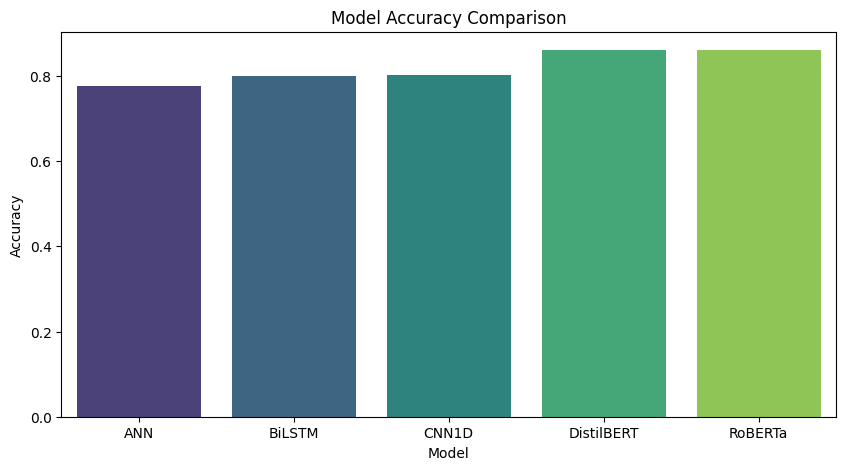

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------
# 1️⃣ Collect predictions
# ---------------------------

# ANN
preds_ann = (ann.predict(X_test, batch_size=512).ravel() >= 0.5).astype(int)

# BiLSTM
preds_bilstm = (bilstm.predict(X_test, batch_size=512).ravel() >= 0.5).astype(int)

# CNN1D
preds_cnn1d = (cnn1d.predict(X_test, batch_size=512).ravel() >= 0.5).astype(int)

# DistilBERT
preds_output_distilbert = trainer.predict(test_ds)  # replace 'trainer' with your DistilBERT trainer if needed
preds_distilbert = np.argmax(preds_output_distilbert.predictions, axis=-1)

# RoBERTa
preds_output_roberta = trainer.predict(test_ds)  # replace 'trainer' with your RoBERTa trainer
preds_roberta = np.argmax(preds_output_roberta.predictions, axis=-1)

# ---------------------------
# 2️⃣ Function to calculate metrics
# ---------------------------
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred, average='weighted'),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted')
    }

# ---------------------------
# 3️⃣ Build comparison table
# ---------------------------
models = ["ANN", "BiLSTM", "CNN1D", "DistilBERT", "RoBERTa"]
predictions = [preds_ann, preds_bilstm, preds_cnn1d, preds_distilbert, preds_roberta]

metrics_list = []
for model_name, pred in zip(models, predictions):
    metrics = get_metrics(y_test, pred)
    metrics["Model"] = model_name
    metrics_list.append(metrics)

df_comparison = pd.DataFrame(metrics_list)
df_comparison = df_comparison[["Model", "Accuracy", "F1-score", "Precision", "Recall"]]

# ---------------------------
# 4️⃣ Display table
# ---------------------------
print("\n✅ Model Comparison Table:\n")
display(df_comparison)

# Optional: plot comparison
plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="Accuracy", data=df_comparison, palette="viridis")
plt.title("Model Accuracy Comparison")
plt.show()
